In [2]:
# Imports
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_theme()

from utils import calculate_nutripoints

# Load the statistical libraries

In [3]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())
print(year_grocery.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


(638, 202)


In [3]:
# year_grocery=year_grocery.sort_values(by='representativeness_norm', ascending=False, ignore_index=True)
year_grocery = year_grocery.nlargest(
    int(0.8*len(year_grocery)), 'representativeness_norm')

In [4]:
#nutripoints=['nutri_energy','nutri_sugar', 'nutri_saturate', 'nutri_sodium', 'nutri_fibre', 'nutri_protein', 'nutri_fruit_veg']
year_grocery["nutripoints"]=year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [4]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


In [5]:
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories
0,E05000026,85.399176,33.243489,43.864852,19.910240,77.527804,2.890336,1.387201,187.114757,1.532485
1,E05000027,87.602703,32.093215,42.057709,20.846778,75.801393,2.917849,1.469422,188.638145,1.541202
2,E05000028,82.946787,32.522242,42.761088,20.769647,78.648192,2.919193,1.577973,186.861792,1.549774
3,E05000029,87.301229,35.651376,51.754425,18.872734,80.338935,2.868373,1.402662,190.783934,1.514848
4,E05000030,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.182663,188.136201,1.540547


In [10]:
len(set(year_grocery["area_id"].values))

638

NameError: name 'column_boxplot' is not defined

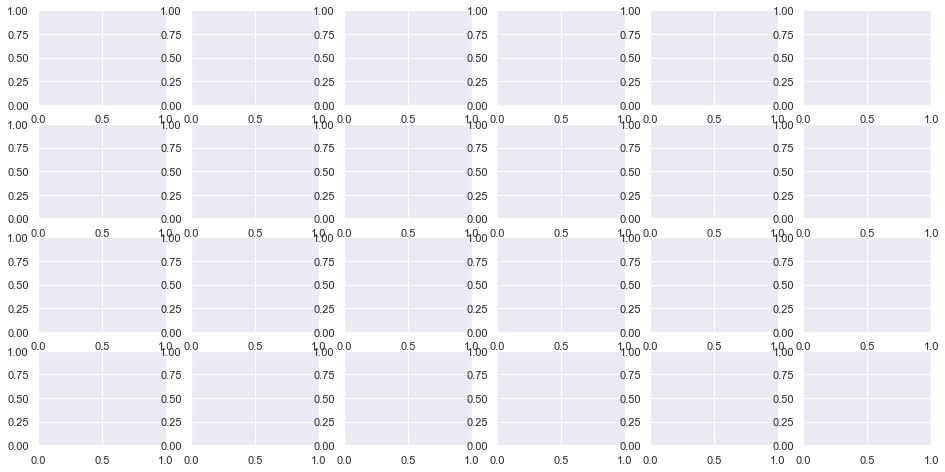

In [11]:
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/6), i % 6]

    sns.histplot(data=wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(wellbeing_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('boxplot for each column', fontsize=18)

In [ ]:
# TO DO correlations

#fig = plt.figure(figsize=(10, 6))

#sns.heatmap(X[FEATURES['EEPD']].corr())

In [ ]:
correlation = year_grocery.corr(method="spearman")
display(correlation)

In [7]:
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation nutripoints")
plt.show()

NameError: name 'correlation' is not defined

<Figure size 1008x216 with 0 Axes>

In [57]:
scaler = StandardScaler()
wellbeing_grocery_analysis[wellbeing_grocery_analysis.columns] = scaler.fit_transform(wellbeing_grocery_analysis
                                                                                      [wellbeing_grocery_analysis.columns])
wellbeing_grocery_analysis.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
count,414.000000,414.000000,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,...,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,0.000000,0.000000,-1.716287e-17,1.716287e-17,-3.432574e-17,-1.716287e-17,-4.290717e-18,-3.432574e-17,2.574430e-17,-8.581434e-18,...,8.581434e-18,8.581434e-18,-8.581434e-18,-4.290717e-18,4.290717e-18,-1.287215e-17,8.581434e-18,1.609019e-17,-2.574430e-17,-2.145359e-17
std,1.001210,1.001210,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,...,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-4.858612,-4.106531,-2.209362e+00,-3.807545e+00,-2.557694e+00,-2.312199e+00,-2.757274e+00,-3.252553e+00,-4.386729e+00,-3.116950e+00,...,-5.361349e+00,-4.579904e+00,-5.415851e+00,-2.918087e+00,-3.289101e+00,-2.769662e+00,-1.769510e+00,-3.236988e+00,-2.266876e+00,-2.621223e+00
25%,-0.591474,-0.633953,-6.748060e-01,-5.022616e-01,-7.102759e-01,-6.822733e-01,-6.951179e-01,-6.479501e-01,-6.496369e-01,-5.731818e-01,...,-6.071623e-01,-5.187806e-01,-3.979695e-01,-7.344486e-01,-6.224379e-01,-6.739686e-01,-7.563159e-01,-7.091274e-01,-8.253661e-01,-7.294591e-01
50%,-0.088255,-0.102794,-1.464485e-01,2.187660e-01,1.172799e-03,-5.706061e-02,-2.918486e-02,7.174067e-03,6.406804e-02,-2.097863e-01,...,2.184025e-01,1.723237e-01,2.604732e-01,-5.006307e-02,8.023090e-02,-5.076569e-02,-2.900224e-01,1.949633e-03,5.969118e-02,4.146312e-02
75%,0.524087,0.537236,6.077119e-01,6.826036e-01,7.163681e-01,6.009698e-01,5.872242e-01,5.933283e-01,7.314173e-01,8.804002e-01,...,7.945244e-01,6.879187e-01,6.774120e-01,6.557210e-01,7.131397e-01,7.993466e-01,5.912542e-01,6.956537e-01,5.236590e-01,6.884352e-01
max,4.148718,4.951899,2.609308e+00,2.133481e+00,2.357185e+00,4.868205e+00,4.181711e+00,2.751558e+00,2.836632e+00,3.787564e+00,...,1.559490e+00,1.901143e+00,1.141527e+00,2.789739e+00,2.239476e+00,2.172853e+00,3.166364e+00,2.780519e+00,2.456041e+00,2.316098e+00


In [30]:
reg_features = 'Q("Life Expectancy") + Q("Incapacity Benefit rate") + Q("Unemployment rate") + Q("Crime rate - Index") \
+ Q("Childhood Obesity") + Q("Homes with access to open space & nature, and % greenspace")'

mod = smf.ols(formula='h_nutrients_calories ~ ' + reg_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     h_nutrients_calories   R-squared:                       0.245
Model:                              OLS   Adj. R-squared:                  0.234
Method:                   Least Squares   F-statistic:                     21.98
Date:                  Mon, 07 Dec 2020   Prob (F-statistic):           2.02e-22
Time:                          10:22:20   Log-Likelihood:                -529.33
No. Observations:                   414   AIC:                             1073.
Df Residuals:                       407   BIC:                             1101.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [31]:
mod = smf.ols(formula='energy_fibre ~ ' + reg_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     52.48
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           9.22e-48
Time:                        10:22:20   Log-Likelihood:                -468.83
No. Observations:                 414   AIC:                             951.7
Df Residuals:                     407   BIC:                             979.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [32]:
wellbeing_scores_columns = wellbeing_scores.columns.values.tolist()
print(wellbeing_scores_columns)

['New ward code', 'Ward name', 'Borough', 'Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate', 'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires', 'Average Capped GCSE and Equivalent Point Score Per Pupil', 'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families', 'Public Transport Accessibility', 'Homes with access to open space & nature, and % greenspace', 'Subjective well-being average score', 'Index Score 2013']


In [33]:
numerical_wellbeing_scores_columns = ['Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate', 'Unemployment rate',
                                      'Crime rate - Index', 'Deliberate Fires',
                                      'Average Capped GCSE and Equivalent Point Score Per Pupil',
                                      'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families',
                                      'Public Transport Accessibility',
                                      'Homes with access to open space & nature, and % greenspace',
                                      'Subjective well-being average score', 'Index Score 2013']

wellbeing_scores_analysis = wellbeing_scores[numerical_wellbeing_scores_columns].dropna(
).copy()
wellbeing_scores_reduced_pca = PCA(n_components=2).fit(
    wellbeing_scores_analysis).transform(wellbeing_scores_analysis)

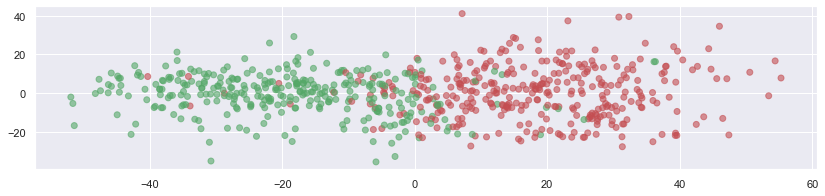

In [34]:
labels = wellbeing_scores_analysis.apply(
    lambda row: "g" if row['Index Score 2013'] >= 0 else "r", axis=1)
# Plot the data reduced in 2d space with PCA
plt.figure(figsize=(14, 3))
plt.scatter(wellbeing_scores_reduced_pca[:, 0],
            wellbeing_scores_reduced_pca[:, 1], c=labels, alpha=0.6)

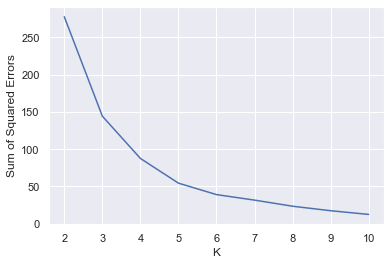

In [35]:
columns_kmeans_health=['h_nutrients_calories', 'energy_alcohol']
columns_kmeans = ['nutripoints']
wellbeing_grocery_kmeans=wellbeing_grocery[columns_kmeans].copy()

def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
        # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(wellbeing_grocery_kmeans)


Text(0, 0.5, 'Silhouette score')

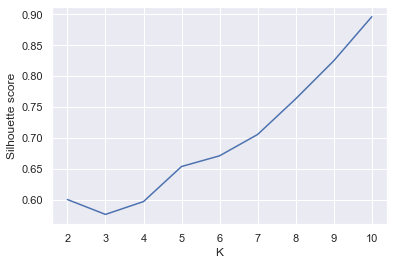

In [36]:
#######    silhouette scores to choose k    #########
silhouettes = []
for k in range(2, 11): # Try multiple k
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(wellbeing_grocery_kmeans)
    # Get the Silhouette score
    score = silhouette_score(wellbeing_grocery_kmeans, labels)
    silhouettes.append({"k": k, "score": score})
    
silhouettes = pd.DataFrame(silhouettes) # Convert to dataframe

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

<AxesSubplot:xlabel='nutripoints'>

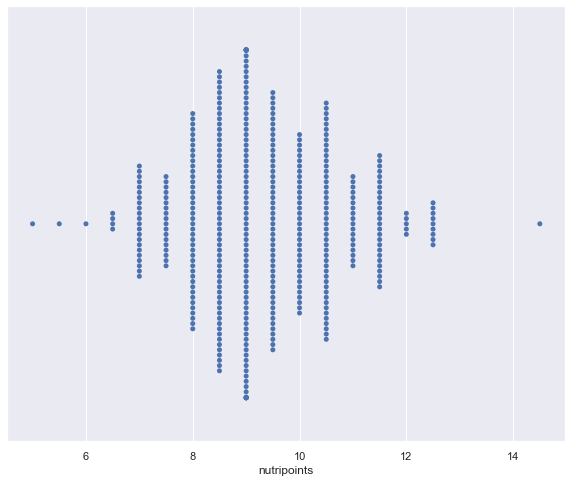

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10,8), sharey=True, sharex=True)

# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(wellbeing_grocery_kmeans)

# Plot the data by using the labels as color
#axs.scatter(wellbeing_grocery_kmeans, wellbeing_grocery_kmeans, c=kmean.labels_)
wellbeing_grocery_kmeans['label']=kmean.labels_
sns.swarmplot(data=wellbeing_grocery_kmeans, x='nutripoints', ax=axs, hue=wellbeing_grocery_kmeans.label)
# Plot the centroids
#for c in kmean.cluster_centers_:
    #axs.scatter(c[0], c[1], marker="+", color="red")

In [38]:
wellbeing_grocery["nutri_label"]=kmean.labels_
wellbeing_grocery.groupby("nutri_label")["nutripoints"].min()

nutri_label
0     9.0
1     8.0
2    11.5
3     5.0
4    10.0
Name: nutripoints, dtype: float64

In [88]:
## linear regression ##
lin_reg = LinearRegression()  # create the model
lin_reg.fit(X,y)  # train it

LinearRegression()

In [89]:
for f in range(len(numerical_wellbeing_scores_columns)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], numerical_wellbeing_scores_columns[f]))
print(lin_reg.intercept_)

-0.09685238336339883 * Life Expectancy + 
-0.022050671834652244 * Childhood Obesity + 
0.10898506439209542 * Incapacity Benefit rate + 
-0.18557034087715332 * Unemployment rate + 
0.04171201464292079 * Crime rate - Index + 
-0.037588487941237855 * Deliberate Fires + 
-0.1250199099028978 * Average Capped GCSE and Equivalent Point Score Per Pupil + 
-0.11371258037672397 * Unauthorised Absence in All Schools (%) + 
-0.0034551831698552194 * Dependent children in out-of-work families + 
-0.14527698037483436 * Public Transport Accessibility + 
0.08046266212260916 * Homes with access to open space & nature, and % greenspace + 
0.023769924485141578 * Subjective well-being average score + 
0.13620742941322708 * Index Score 2013 + 
-3.608440511979806e-18


In [90]:
reg2_features='Q("Life Expectancy")+Q("Childhood Obesity")+Q("Incapacity Benefit rate")+Q("Unemployment rate")\
                + Q("Crime rate - Index")+Q("Deliberate Fires")+\
                Q("Average Capped GCSE and Equivalent Point Score Per Pupil")+\
                Q("Unauthorised Absence in All Schools (%)")+Q("Dependent children in out-of-work families")+\
                Q("Public Transport Accessibility")+ Q("Homes with access to open space & nature, and % greenspace")+\
                Q("Subjective well-being average score")+Q("Index Score 2013")'
mod = smf.ols(formula='nutripoints ~ ' + reg2_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.372
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           6.15e-05
Time:                        10:59:41   Log-Likelihood:                -565.91
No. Observations:                 414   AIC:                             1160.
Df Residuals:                     400   BIC:                             1216.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [91]:
reg2_features='Q("Life Expectancy")+Q("Childhood Obesity")+Q("Incapacity Benefit rate")+Q("Unemployment rate")\
                + Q("Crime rate - Index")+Q("Deliberate Fires")+\
                Q("Average Capped GCSE and Equivalent Point Score Per Pupil")+\
                Q("Unauthorised Absence in All Schools (%)")+Q("Dependent children in out-of-work families")+\
                Q("Public Transport Accessibility")+ Q("Homes with access to open space & nature, and % greenspace")+\
                Q("Subjective well-being average score")'
mod = smf.ols(formula='nutripoints ~ ' + reg2_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.588
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           4.20e-05
Time:                        10:59:42   Log-Likelihood:                -566.33
No. Observations:                 414   AIC:                             1159.
Df Residuals:                     401   BIC:                             1211.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [104]:
X = wellbeing_grocery_analysis[numerical_wellbeing_scores_columns]
y = wellbeing_grocery_analysis["nutripoints"]

In [92]:
# train a gradient boosting regressor
gradboost = GradientBoostingRegressor()

# compute r^2 for this new model
#r2_random_gradboost = gradboost_random.score(train_X, train_y)

#print(f"R² for the Gradient Boost Regression: {r2_random_gradboost}")

In [108]:
selector=RFE(gradboost,n_features_to_select=5, step=1)
selector=selector.fit(X,y)
print(X.columns)
print(selector.ranking_)

Index(['Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate',
       'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires',
       'Average Capped GCSE and Equivalent Point Score Per Pupil',
       'Unauthorised Absence in All Schools (%)',
       'Dependent children in out-of-work families',
       'Public Transport Accessibility',
       'Homes with access to open space & nature, and % greenspace',
       'Subjective well-being average score', 'Index Score 2013'],
      dtype='object')
[1 7 6 4 5 9 1 3 1 1 2 1 8]


In [95]:
predicted_y = cross_val_predict(gradboost, X, y, cv=5)

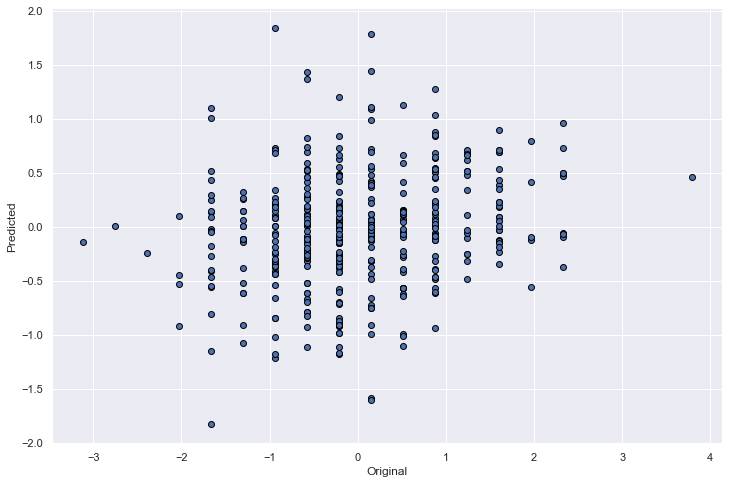

In [100]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [101]:
r2=r2_score(y, predicted_y)
mse=mean_squared_error(y, predicted_y)
print(r2, mse)

-0.05315851843872532 1.0531585184387253
